# Determining the cost of cars

Service for the sale of used cars "Not beaten, not beautiful" is developing an application to attract new customers. In it, you can quickly find out the market value of your car. At your disposal are historical data: technical specifications, equipment and prices of cars. You need to build a model to determine the cost.

The customer is important:

- quality of prediction;
- prediction speed;
- studying time.

<font size=4><b>Data Description</b></font>

<b>Features:</b>

- `DateCrawled` — date of downloading the profile from the database
- `VehicleType` — car body type
- `RegistrationYear` - year of car registration
- `Gearbox` — gearbox type
- `Power` - power (hp)
- `Model` — car model
- `Kilometer` — mileage (km)
- `RegistrationMonth` — car registration month
- `FuelType` — fuel type
- `Brand` — car brand
- `NotRepaired` - was the car under repair or not
- `DateCreated` — date of creation of the questionnaire
- `NumberOfPictures` - the number of photos of the car
- `PostalCode` — postal code of the owner of the profile (user)
- `LastSeen` — date of last user activity

<b>Target feature:</b>
- `Price` — price (euro)

## Data preparation

In [1]:
#load the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

import time
import warnings
warnings.filterwarnings('ignore')

### Getting to know the data

In [2]:
try:
    df = pd.read_csv('C:/Users/Ruslanio/Downloads/autos.csv')
except FileNotFoundError:
    print("File not found.")
except pd.errors.EmptyDataError:
    print("No data")
except pd.errors.ParserError:
    print("Parse error")
except Exception:
    print("Some other exception")

In [3]:
#look at the dataset
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
37359,2016-03-30 13:57:24,3800,small,2008,manual,68,fusion,150000,4,gasoline,ford,no,2016-03-30 00:00:00,0,28844,2016-04-07 05:15:35
282031,2016-03-25 12:47:41,3950,small,2009,manual,69,ka,20000,6,petrol,ford,no,2016-03-25 00:00:00,0,45889,2016-03-30 01:46:53
233127,2016-04-02 09:54:53,7299,wagon,2010,manual,101,focus,60000,6,petrol,ford,no,2016-04-02 00:00:00,0,48356,2016-04-04 07:17:35
218227,2016-03-25 16:46:59,1500,small,2003,manual,75,corsa,90000,5,petrol,opel,no,2016-03-25 00:00:00,0,48529,2016-03-30 07:16:40
108567,2016-03-11 13:57:49,6300,sedan,2008,manual,177,3er,150000,4,gasoline,bmw,yes,2016-03-11 00:00:00,0,59555,2016-03-17 20:48:45
161010,2016-03-19 16:53:45,1200,small,2001,manual,50,polo,150000,2,petrol,volkswagen,no,2016-03-19 00:00:00,0,40599,2016-03-21 22:44:19
338095,2016-04-02 16:57:37,1700,NaN,1995,manual,1503,a4,150000,5,petrol,audi,no,2016-04-02 00:00:00,0,78234,2016-04-06 16:16:09
350434,2016-03-25 08:25:22,1450,wagon,1996,manual,170,3er,150000,8,NaN,bmw,no,2016-03-25 00:00:00,0,65933,2016-03-30 00:46:10
236876,2016-04-04 02:59:52,13900,suv,2004,auto,450,cayenne,150000,5,petrol,porsche,no,2016-04-04 00:00:00,0,81247,2016-04-06 09:17:16
184667,2016-03-25 11:41:27,650,small,2002,manual,75,twingo,150000,6,petrol,renault,no,2016-03-25 00:00:00,0,45665,2016-03-25 11:41:27


In [4]:
#look at the general information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

The dataset has 354,369 rows and 16 columns. The format of the columns is correct, except for the columns with the date, but we will remove them from the dataset, because they do not carry any necessary information for training models.

In [5]:
#take a look at the descriptive feature statistics
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


There are gaps and incorrect data in the dataset, such as the year of registration of the car, power or price.

In [6]:
#look at the number of duplicates in the dataset
print('Number of duplicates in the dataset:', df.duplicated().sum())

Number of duplicates in the dataset: 4


In [7]:
#and look at the number of passes
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [8]:
#check the maximum date of uploading the questionnaire in order to understand what year of manufacture cars can be
df['DateCrawled'].max()

'2016-04-07 14:36:58'

The questionnaire was uploaded in 2016.

The dataset has many gaps in the `VehicleType`, `Gearbox`, `Model`, `FuelType` and `NotRepaired` columns.

### Data preprocessing

First, let's remove 4 duplicates.

In [9]:
df = df.drop_duplicates()
print('Number of duplicates in the dataset:', df.duplicated().sum())

Number of duplicates in the dataset: 0


In [10]:
#reduce the names of all columns to lowercase
#df.columns = df.columns.str.lower()

Now let's remove the columns that are not needed for our model: `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`.

In [11]:
df = df.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated',
              'NumberOfPictures', 'PostalCode', 'LastSeen'], axis=1)
df.sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
162343,15500,suv,2003,auto,292,NaN,100000,petrol,sonstige_autos,NaN
328075,4100,convertible,1996,manual,150,3er,150000,petrol,bmw,no
192744,2999,sedan,2005,manual,105,astra,150000,petrol,opel,no
328771,9000,bus,2009,manual,105,touran,150000,gasoline,volkswagen,no
176612,1250,bus,2000,manual,101,zafira,150000,gasoline,opel,no


In [12]:
#check how many rows with zero price
len(df[df['Price'] == 0])

10772

The dataset contains data with a zero price. Because this data is the target feature, and there is nothing to replace them with, then we will not use these rows

In [13]:
df = df[df['Price'] > 0].reset_index(drop=True)
len(df[df['Price'] == 0])

0

Now let's move on to passes.

In [14]:
#look again at the gaps
df.isna().sum()

Price                   0
VehicleType         33750
RegistrationYear        0
Gearbox             17355
Power                   0
Model               17521
Kilometer               0
FuelType            29459
Brand                   0
NotRepaired         65866
dtype: int64

<b>Let's start with the `NotRepaired` column. Let's look at the unique values in this column.</b>

In [15]:
df['NotRepaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

We have 3 values in this column: 'yes', 'no' and nan. Let's replace 'yes' with 1, 'no' with 0, we'll also replace gaps with 0, because since nothing was indicated in this column, it means, most likely, there was nothing to indicate and the car was not repaired.

In [16]:
df['NotRepaired'] = df['NotRepaired'].replace({'yes':1, 'no':0})

In [17]:
df['NotRepaired'] = df['NotRepaired'].fillna(0).astype(int)

In [18]:
#check if the replacement was successful
df['NotRepaired'].unique()

array([0, 1])

<b>Now let's deal with outliers in the `RegistrationYear` and `Power` columns.</b>

As we know, the first car was produced by Karl Benz in 1885 and it was called "Benz Patent-Motorwagen". Therefore, all dates before 1885 and after 2022 are outliers. And because the year of registration of the car is very important information, we cannot replace it with any average values. To determine the boundaries of outliers, we will construct a boxplot.

(1980.0, 2020.0)

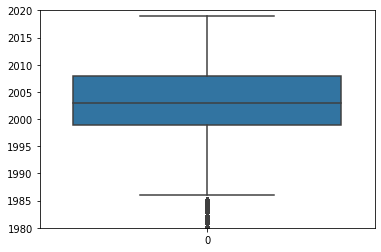

In [19]:
sns.boxplot(data=df['RegistrationYear'])
plt.ylim(1980, 2020)

The histogram shows that emissions begin before 1986 and after 2016. Let's filter this data.

In [20]:
print('Number of rows with incorrect year:', len(df.query('RegistrationYear < 1986 or RegistrationYear > 2016')))

Number of rows with incorrect year: 19436


In [21]:
df = df.query('RegistrationYear >= 1986 and RegistrationYear <= 2017')

As we remember from the descriptive table in the `Power` column, the minimum value is 0 and the maximum value is 20,000. These are clearly outliers and therefore we need to replace these data with median values depending on the car model. To date, the most powerful car is the Lotus Evija with 2,000 horsepower. But to determine the boundary of outliers, let's build a boxplot.

(0.0, 400.0)

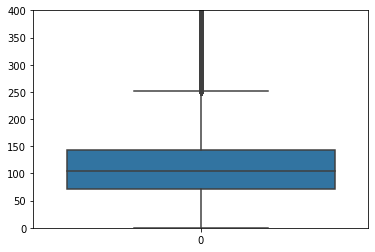

In [22]:
sns.boxplot(data=df['Power'])
plt.ylim(0, 400)

You can see in the histogram that emissions start after 260 horsepower.

In [23]:
print('Number of rows with incorrect cardinality:', len(df.query('Power == 0 or Power > 260')))

Number of rows with incorrect cardinality: 40229


In [24]:
#replace incorrect values in the column with gaps
df.loc[(df['Power'] == 0) | (df['Power'] > 260), 'Power'] = None

In [25]:
#and now replace gaps with medians depending on the model
df['Power'] = df['Power'].fillna(df.groupby('Model')['Power'].transform('median'))
df.isna().sum()

Price                   0
VehicleType         29097
RegistrationYear        0
Gearbox             15838
Power                4843
Model               15839
Kilometer               0
FuelType            26856
Brand                   0
NotRepaired             0
dtype: int64

And the gaps remaining in the `Power` column will be replaced by medians depending on the brand of the car.

In [26]:
df['Power'] = df['Power'].fillna(df.groupby('Brand')['Power'].transform('median'))
df.isna().sum()

Price                   0
VehicleType         29097
RegistrationYear        0
Gearbox             15838
Power                   0
Model               15839
Kilometer               0
FuelType            26856
Brand                   0
NotRepaired             0
dtype: int64

We still have gaps in the `VehicleType`, `Gearbox`, `Model` and `FuelType` columns. The data of the `Model` column is the main one for training the model and it will not be possible to restore this data, so we will replace the gaps in this column with the model type `Other`. The data of the `VehicleType`, `Gearbox` and `FuelType` columns will be filled in based on the most common data in similar car models.

In [27]:
print('The percentage of missing data by models from the entire dataset:', (df['Model'].isna().sum()/len(df))*100)

The percentage of missing data by models from the entire dataset: 4.741477374779975


Five percent of the dataset is a lot, you can’t delete it. Let's replace gaps with `Other`.

In [28]:
df['Model'] = df['Model'].fillna('other')

#check the number of remaining gaps in the given column
df['Model'].isna().sum()

0

There are gaps in 3 more columns. And since they contain categorical data, replacing them with a median or an average will not work. We need to calculate the most frequent number of values for a specific car model in the features in which we will replace the gaps and replace the gaps with this most frequent value.Остались пропуски еще в 3 столбцах. И так как в них содержатся категориальные данные, то заменить их медианой или средним не получится. Нужно посчитать самое частое количество значений для конкретной модели автомобиля в признаках, в которых будем заменять пропуски и заменить пропуски этим самым частым значением.

In [29]:
#let's write a lambda function, because the data is transformed by the function
#and the standard functions of the transform method won't work for us here
df['VehicleType'] = df['VehicleType']\
.fillna(df.groupby('Model')['VehicleType']\
.transform(lambda x: x.value_counts().idxmax())) 

In [30]:
df['Gearbox'] = df['Gearbox']\
.fillna(df.groupby('Model')['Gearbox']\
.transform(lambda x: x.value_counts().idxmax())) 

In [31]:
df['FuelType'] = df['FuelType']\
.fillna(df.groupby('Model')['FuelType']\
.transform(lambda x: x.value_counts().idxmax())) 

In [32]:
#check if there are still gaps in the dataset
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
NotRepaired         0
dtype: int64

### Data Encoding and Sampling

Let's look again at our dataset to understand whether to use direct or ordinal encoding.

In [33]:
df.sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
250970,8750,bus,2010,manual,109.0,berlingo,150000,gasoline,citroen,0
117802,3800,small,2002,manual,116.0,cooper,90000,petrol,mini,0
204507,2800,small,2017,auto,61.0,fortwo,150000,gasoline,smart,0
230940,18300,wagon,2012,auto,170.0,passat,80000,gasoline,volkswagen,0
222659,3890,sedan,2010,manual,60.0,punto,125000,cng,fiat,0


Let's save separately our categorical features without coding in order to compare the result of training the model on them with and without coding.

If you use direct coding (OHE), there will be a lot of columns, because we need to encode both brand and model, where there is a lot of data, so we apply ordinal coding (OE) to our categorical features. But since linear regression requires direct coding, we will prepare a separate dataset for linear regression.

In [34]:
df_ohe = pd.get_dummies(df, drop_first=True)
df_ohe.sample(5)

,Price,RegistrationYear,Power,Kilometer,NotRepaired,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_seat,Brand_skoda,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo
202927,1990,1993,68.0,150000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
194802,600,1996,102.0,150000,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23750,1499,1998,165.0,150000,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
136766,12500,2011,143.0,90000,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
151996,12200,2008,184.0,100000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
#and immediately prepare the features for linear regression
features_ohe = df_ohe.drop(['Price'], axis=1)
target_ohe = df_ohe['Price'].reset_index(drop=True)

features_train_ohe, features_test_ohe, target_train_ohe, target_test_ohe = train_test_split(
    features_ohe, target_ohe, test_size=0.25, random_state=12345)

print('OHE training sample size:', len(target_train_ohe))
print('OHE test sample size:', len(target_test_ohe))

OHE training sample size: 250539
OHE test sample size: 83513


And for the other three models, we will prepare data with ordinal coding and for comparison without coding at all.

In [36]:
features = df.drop(['Price'], axis=1)
target = df['Price'].reset_index(drop=True)

features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=12345)

print('Training sample size:', len(target_train))
print('Test sample size:', len(target_test))

Training sample size: 250539
Test sample size: 83513


In [37]:
df_oe = df.copy(deep=True)
category = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand']
encoder = OrdinalEncoder()

df_oe[category] = encoder.fit_transform(df_oe[category])

In [38]:
# check if everything worked out
df_oe.sample(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
181228,6890,7.0,2006,1.0,102.0,62.0,90000,6.0,38.0,0
181034,7399,4.0,2008,1.0,102.0,163.0,100000,6.0,31.0,0
1426,2500,4.0,2000,0.0,136.0,11.0,150000,2.0,2.0,0
15186,300,7.0,1998,1.0,101.0,42.0,150000,6.0,24.0,1
86239,2900,0.0,2011,1.0,75.0,166.0,150000,2.0,25.0,0


Encoding was successful. Now let's scale the features and divide our sample into training and test in a ratio of 3:1.

In [39]:
#to begin with, we separate the features and the target feature
features_oe = df_oe.drop(['Price'], axis=1)
target_oe = df_oe['Price'].reset_index(drop=True)

In [40]:
#now let's standardize the data
scategory = ['RegistrationYear', 'Power', 'Kilometer', 'NotRepaired'] #scategory - scaled category
scaler = StandardScaler()
features_oe[scategory] = scaler.fit_transform(features_oe[scategory])
features_oe.sample(5)

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,NotRepaired
7075,4.0,1.056751,0.0,1.470223,11.0,-0.105326,2.0,2.0,-0.333282
323233,5.0,0.570431,1.0,-1.283184,224.0,0.571564,6.0,27.0,-0.333282
185837,7.0,0.570431,1.0,0.508716,154.0,-0.105326,2.0,10.0,-0.333282
124835,1.0,-0.077996,0.0,1.164289,29.0,-0.105326,6.0,1.0,-0.333282
233439,5.0,-0.726422,1.0,-1.370593,166.0,0.571564,6.0,24.0,-0.333282


In [41]:
#and divide our sample into training and testing in a ratio of 3:1
features_train_oe, features_test_oe, target_train_oe, target_test_oe = train_test_split(
    features_oe, target_oe, test_size=0.25, random_state=12345)

print('Training sample size OE:', len(target_train_oe))
print('OE test sample size:', len(target_test_oe))

Training sample size OE: 250539
OE test sample size: 83513


All the data is prepared, you can start training the models.

### Section Conclusion

1. There are 354,369 rows and 16 columns in the dataset. The columns are formatted correctly.
2. There are gaps and incorrect data in the dataset, for example, the year of registration of the car, power or price.
3. There are a lot of gaps and 4 duplicates in the dataset.
4. 4 gaps and columns that are not needed for our model were removed: `DateCrawled`, `RegistrationMonth`, `DateCreated`, `NumberOfPictures`, `PostalCode`, `LastSeen`.
5. Data with a zero price has been deleted, because. these data are the target feature, and there is nothing to replace them with.
6. Columns with gaps in the model data have been removed, all other gaps have been replaced.
7. Ordinal coding, data scaling were applied to the dataset, and the dataset was divided into training and validation samples in a ratio of 3:1.

## Model training

Here we will train 4 models: Linear Regression, Random Forest, Catboost and LightGBM. Let's start with the simplest and fastest model - linear regression.

In [42]:
# first create a function for calculating RMSE
def rmse(target, prediction):
    return mean_squared_error(target, prediction)**0.5

### Linear Regression

To begin with, we will train the simplest model - linear regression.

In [43]:
linear_model = LinearRegression()
#check the training time of linear regression
start_lin_train = time.time()
linear_model.fit(features_train_ohe, target_train_ohe)
end_lin_train = time.time()

#and find out the time of prediction
start_lin_pred = time.time()
linear_prediction = linear_model.predict(features_test_ohe)
end_lin_pred = time.time()

print('The RMSE of linear regression is:', rmse(target_test_ohe, linear_prediction))
print('Linear regression training time:', end_lin_train - start_lin_train)
print('Linear regression prediction time:', end_lin_pred - start_lin_pred)

The RMSE of linear regression is: 2683.4145624547896
Linear regression training time: 3.219515800476074
Linear regression prediction time: 0.06758475303649902


Результат RMSE линейной регрессии составил 2683.46, время обучения - 31.9 s, а на предсказание ушло 192 ms.

### Random Forest

For the selection of random forest parameters, we use GridSearchCV.

In [44]:
%%time

forest_model = RandomForestRegressor(random_state=12345)
forest_params = {'n_estimators':range(10, 50, 10), 'max_depth':range(10, 15)}
forest_grid = GridSearchCV(forest_model, forest_params, cv=5, scoring = 'neg_root_mean_squared_error', n_jobs=-1)
forest_grid.fit(features_train_oe, target_train_oe)

print('Best Random Forest Options:', forest_grid.best_params_)
print('The best score of random forest is:', forest_grid.best_score_)

Best Random Forest Options: {'max_depth': 14, 'n_estimators': 40}
The best score of random forest is: -1742.8565774729898
CPU times: total: 12.2 s
Wall time: 2min 40s


In [45]:
#check Forest OE training time
forest_model = RandomForestRegressor(random_state=12345, max_depth=14, n_estimators=40)
start_for_train = time.time()
forest_model.fit(features_train_oe, target_train_oe)
end_for_train = time.time()

#check Forest OE prediction time
start_for_pred = time.time()
forest_prediction_oe = forest_model.predict(features_train_oe)
end_for_pred = time.time()

print('The RMSE of a random forest is:', rmse(target_train_oe, forest_prediction_oe))
print('Forest training time:', end_for_train - start_for_train)
print('Forest prediction time:', end_for_pred - start_for_pred)

The RMSE of a random forest is: 1487.5735854081618
Forest training time: 11.491591215133667
Forest prediction time: 1.2207086086273193


The random forest has a much better RMSE of 1487.57, but the training time was 8 min 25 s and the prediction time was 5.48 µs.

### Catboost

In [46]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired', 'Brand']  

When training Catboost, we will also use GridSearchCV.

In [47]:
%%time

cat_model_oe = CatBoostRegressor(iterations=100, verbose=False, random_state=12345)
cat_params_oe = {'learning_rate':[0.05, 0.1], #learning rate
                 'depth':[5, 10, 15]} #tree depth
cat_grid_oe = GridSearchCV(cat_model_oe, cat_params_oe, cv=5, scoring = 'neg_root_mean_squared_error', n_jobs=-1)
cat_grid_oe.fit(features_train_oe, target_train_oe)

print('The best parameters of Catboost OE:', cat_grid_oe.best_params_)
print('Best score of Catboost OE:', cat_grid_oe.best_score_)

The best parameters of Catboost OE: {'depth': 15, 'learning_rate': 0.1}
Best score of Catboost OE: -1694.4157404783705
CPU times: total: 1min 16s
Wall time: 2min 28s


In [48]:
#check Catboost OE training time
cat_model_oe = CatBoostRegressor(iterations=100, verbose=False,
                              random_state=12345, learning_rate=0.1, depth=15)
start_cat_train = time.time()
cat_model_oe.fit(features_train_oe, target_train_oe)
end_cat_train = time.time()

#check Catboost OE prediction time
start_cat_pred = time.time()
cat_prediction_oe = cat_model_oe.predict(features_train_oe)
end_cat_pred = time.time()

print('RMSE Catboost OE is:', rmse(target_train_oe, cat_prediction_oe))
print('Catboost OE training time:', end_cat_train - start_cat_train)
print('Catboost OE prediction time:', end_cat_pred - start_cat_pred)

RMSE Catboost OE is: 1575.1407253038112
Catboost OE training time: 28.63345503807068
Catboost OE prediction time: 0.0610198974609375


In [49]:
#sampling without encoding
cat_model = CatBoostRegressor(iterations=100, verbose=False, cat_features = cat_features,
                              random_state=12345, learning_rate=0.1, depth=15)
start_cat_train = time.time()
cat_model.fit(features_train, target_train)
end_cat_train = time.time()

#check Catboost prediction time
start_cat_pred = time.time()
cat_prediction = cat_model.predict(features_train)
end_cat_pred = time.time()

print('RMSE Catboost is:', rmse(target_train, cat_prediction))
print('Catboost training time without encoding:', end_cat_train - start_cat_train)
print('Catboost prediction time without encoding:', end_cat_pred - start_cat_pred)

RMSE Catboost is: 1548.2256095897415
Catboost training time without encoding: 37.21108889579773
Catboost prediction time without encoding: 0.37299633026123047


Catboost performed worse than random forest and RMSE on the sample with coded features was 1575.14, and on the sample without coded features - 1548.22, which indicates that Catboost does not require feature encoding. At the same time, the training time of Catboost is higher than that of random forest, and the prediction time is better.

### LightGBM

Light Gradient Boosted Machine (LightGBM) is an open source library that provides an efficient and efficient implementation of the gradient boosting algorithm.

LightGBM extends the gradient boosting algorithm by adding an automatic feature selection type and also focusing on boosting examples with large gradients. This can lead to a dramatic acceleration of learning and improved predictive performance. Thus, LightGBM has become the de facto algorithm for machine learning competitions when working with tabular data for regression and classification predictive modeling problems.

A feature of LightGBM is that it supports a number of boosting algorithms called boost types:
1. `gbdt`: gradient boosted decision tree (GDBT);
2. `dart`: the concept of dropout is introduced into MART, we get DART;
3. `goss`: gradient based one-sided sampling (GOSS).

In [50]:
#change the categorical data type to category
features_train[['VehicleType','Gearbox', 'Model', 'FuelType','Brand','NotRepaired']]=\
features_train[['VehicleType','Gearbox', 'Model', 'FuelType','Brand','NotRepaired']].astype('category')

In [51]:
%%time

gbm_model_oe = LGBMRegressor(random_state=12345)
gbm_params_oe = {'n_estimators':[100, 150], #number of decision trees
              'num_leaves':[10, 15]} #number of terminal nodes (leaves) of the tree
gbm_grid_oe = GridSearchCV(gbm_model_oe, gbm_params_oe, cv=5, scoring = 'neg_root_mean_squared_error', n_jobs=-1)
gbm_grid_oe.fit(features_train_oe, target_train_oe)

print('The best parameters of LightGBM OE:', gbm_grid_oe.best_params_)
print('Best score LightGBM OE:', gbm_grid_oe.best_score_)

The best parameters of LightGBM OE: {'n_estimators': 150, 'num_leaves': 15}
Best score LightGBM OE: -1830.2342605839992
CPU times: total: 5.05 s
Wall time: 5.79 s


In [52]:
#check the learning time of LightGBM OE
gbm_model_oe = LGBMRegressor(random_state=12345, n_estimators=150, num_leaves=15)
start_gbm_train = time.time()
gbm_model_oe.fit(features_train_oe, target_train_oe)
end_gbm_train = time.time()

#check the prediction time LightGBM OE
start_gbm_pred = time.time()
gbm_prediction_oe = gbm_model_oe.predict(features_train_oe)
end_gbm_pred = time.time()
print('RMSE LightGBM OE is:', rmse(target_train_oe, gbm_prediction_oe))
print('LightGBM OE training time:', end_gbm_train - start_gbm_train)
print('LightGBM OE prediction time:', end_gbm_pred - start_gbm_pred)

RMSE LightGBM OE is: 1811.7101608505852
LightGBM OE training time: 0.4388260841369629
LightGBM OE prediction time: 0.19547748565673828


In [53]:
#selection without encoding
gbm_model = LGBMRegressor(random_state=12345, n_estimators=150, num_leaves=15)
start_gbm_train = time.time()
gbm_model.fit(features_train, target_train, categorical_feature=cat_features, verbose=False)
end_gbm_train = time.time()

#check LightGBM prediction time
start_gbm_pred
gbm_prediction = gbm_model.predict(features_train)
end_gbm_pred
print('RMSE LightGBM is:', rmse(target_train, gbm_prediction))
print('LightGBM training time:', end_gbm_train - start_gbm_train)
print('LightGBM prediction time:', end_gbm_pred - start_gbm_pred)

RMSE LightGBM is: 1701.2660451654126
LightGBM training time: 0.5784528255462646
LightGBM prediction time: 0.19547748565673828


LightGBM performed even worse than Catboost with RMSE 1811.71 on the encoded sample and RMSE 1701.26 on the unencoded sample. At the same time, its learning rate is several times higher than that of all previous models, but the prediction rate is the lowest.

### Dummy Regressor

And to check the adequacy of our models, we will train the Dummy model.

In [54]:
%%time

dummy_model = DummyRegressor(strategy='mean')
dummy_model.fit(features_train, target_train)
dummy_prediction = dummy_model.predict(features_train)
print('The RMSE of the dummy model is:', rmse(target_train, dummy_prediction))

The RMSE of the dummy model is: 4507.915668227669
CPU times: total: 0 ns
Wall time: 3.67 ms


All trained models performed better than DummyRegressor.

### Section Conclusion

1. 4 models were trained: Linear Regression, Random Forest, Catboost and LightGBM.
2. Random forest showed the best RMSE result - 1487.57, Catboost has the highest prediction rate, and LightGBM has the highest learning rate.
3. Comparison of the Catboost and LightGBM models on coded features and standard ones showed an interesting result that these models perform better on samples that did not have feature encoding applied.
4. All models performed better than DummyRegressor.

## Анализ моделей

In [55]:
#make a comparison table with the received data
data={'Model': ['Linear Regression', 'RandomForest', 'CatBoost OE', 'CatBoost', 'LightGBM OE', 'LightGBM', 'DummyModel'],
      'RMSE': [2683.46, 1487.57, 1575.14, '1548.22', 1811.71, '1701.26', 4507.91],
      'Model training time':['26.96 s' , '17.12 s', '58.54 s', '63.21 s', '4.79 s', '4.96 s', '3.52 ms'],
      'Model prediction time' : ['0.14 s', '1.45 s', '0.21 s', '0.56 s', '2.02 s', '2.02 s', '3.52 ms']}
data_pivot=pd.DataFrame.from_dict(data)
display(data_pivot)

,Model,RMSE,Model training time,Model prediction time
0,Linear Regression,2683.46,26.96 s,0.14 s
1,RandomForest,1487.57,17.12 s,1.45 s
2,CatBoost OE,1575.14,58.54 s,0.21 s
3,CatBoost,1548.22,63.21 s,0.56 s
4,LightGBM OE,1811.71,4.79 s,2.02 s
5,LightGBM,1701.26,4.96 s,2.02 s
6,DummyModel,4507.91,3.52 ms,3.52 ms


Let's check the operation of the random forest on a test sample.

In [56]:
model = RandomForestRegressor(n_estimators=40, max_depth=14, random_state=12345)
model.fit(features_train_oe, target_train_oe)
prediction = model.predict(features_test_oe)
print('The RMSE of a random forest is:', rmse(target_test_oe, prediction))

The RMSE of a random forest is: 1724.0286377522802


 On the test sample, the result turned out to be worse than on the training sample, but still this is a fairly high result.

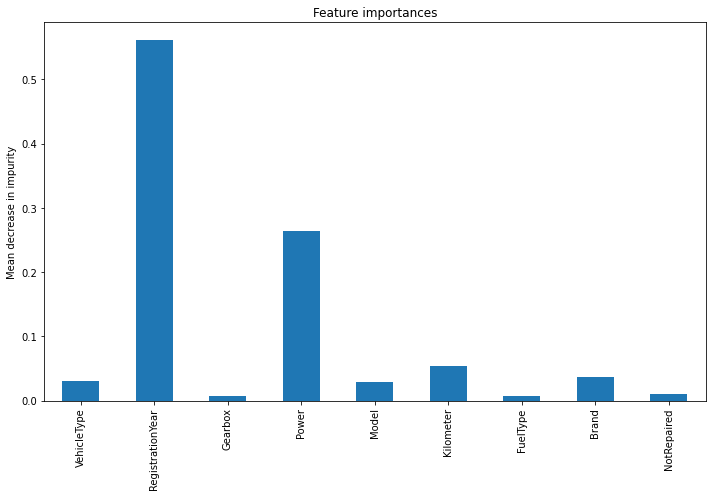

In [57]:
feature_names = features_oe.columns 
model = RandomForestRegressor(n_estimators=40, max_depth=14, random_state=12345)
model.fit(features_train_oe, target_train_oe)
pred = model.predict(features_test_oe)
importances = model.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([model.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## Conclusion

1. According to the results of the study, we can conclude that gradient boosting is superior to linear regression in terms of the quality of predictions.
2. <b>The best model</b> in terms of performance / speed <b>is Random Forest</b> because it has the lowest RMSE result among all models, and the learning and prediction speed is between Catboost and LightGBM .